In [1]:
from Archivos_Apoyo.AngleCouplingAnalyzer import AngleCouplingAnalyzer
ruta_entrenamiento_robot="logs_lift_leg/general_values_20251008_205609.pid16436.csv"
ruta_recompensas="logs_lift_leg/rewards_20251008_205609.pid16436.csv"
anglecouplinganalyzer=AngleCouplingAnalyzer()

In [2]:
df_general=anglecouplinganalyzer.cargar_csv(ruta_entrenamiento_robot)
df_recompensas=anglecouplinganalyzer.cargar_csv(ruta_recompensas)

In [3]:
angulos_joints=anglecouplinganalyzer.split_parameters_df(df_general, startswith="q_")
angular_speed=anglecouplinganalyzer.split_parameters_df(df_general, startswith="vel_")
torque=anglecouplinganalyzer.split_parameters_df(df_general, startswith="τ_reaction_")
forces=anglecouplinganalyzer.split_parameters_df(df_general, startswith="Forces_")
pressures=anglecouplinganalyzer.split_parameters_df(df_general, startswith="Pressure_")
coms=anglecouplinganalyzer.split_parameters_df(df_general, startswith="COM_")
zmps=anglecouplinganalyzer.split_parameters_df(df_general, startswith="ZMP_")
df_angle_speed = df_general.loc[:, df_general.columns.str.startswith(("q_", "vel_"))]
df_angle_com = df_general.loc[:, df_general.columns.str.startswith(("q_left_hip", "q_right_hip", "COM_"))]
df_presiones_velocidades=df_general.loc[:, df_general.columns.str.startswith(("vel_", "Pressure_"))]

In [4]:
df_presiones_velocidades

,vel_left_hip_roll_joint,Pressure_left_hip_roll_jointflexion,Pressure_left_hip_roll_jointextension,vel_left_hip_pitch_joint,Pressure_left_hip_pitch_jointflexion,Pressure_left_hip_pitch_jointextension,vel_left_knee_joint,Pressure_left_knee_jointflexion,Pressure_left_knee_jointextension,vel_left_anckle_joint,...,Pressure_right_hip_roll_jointextension,vel_right_hip_pitch_joint,Pressure_right_hip_pitch_jointflexion,Pressure_right_hip_pitch_jointextension,vel_right_knee_joint,Pressure_right_knee_jointflexion,Pressure_right_knee_jointextension,vel_right_anckle_joint,Pressure_right_anckle_jointflexion,Pressure_right_anckle_jointextension
0,-1.326,0.000000,0.000000,-34.507,0.000000,0.0,3.269,0.0,0.832295,0.052,...,0.000000,35.445,0.163493,0.000000,3.793,0.28039,0.000000,-0.093,0.0,0.000000
1,-1.326,0.000000,0.000000,-34.507,0.000000,0.0,3.269,0.0,0.832295,0.052,...,0.000000,35.445,0.163493,0.000000,3.793,0.28039,0.000000,-0.093,0.0,0.000000
2,-1.326,0.000000,0.000000,-34.507,0.000000,0.0,3.269,0.0,0.832295,0.052,...,0.000000,35.445,0.163493,0.000000,3.793,0.28039,0.000000,-0.093,0.0,0.000000
3,-1.326,0.000000,0.000000,-34.507,0.000000,0.0,3.269,0.0,0.832295,0.052,...,0.000000,35.445,0.163493,0.000000,3.793,0.28039,0.000000,-0.093,0.0,0.000000
4,-1.326,0.000000,0.000000,-34.507,0.000000,0.0,3.269,0.0,0.832295,0.052,...,0.000000,35.445,0.163493,0.000000,3.793,0.28039,0.000000,-0.093,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,-0.890,0.000000,0.000000,0.558,0.000000,1.0,0.001,1.0,0.000000,-0.000,...,1.000000,0.032,0.000000,0.192947,0.319,1.00000,0.000000,0.250,0.0,0.227703
571,-0.281,0.000000,0.325977,1.122,0.000000,1.0,0.000,1.0,0.000000,-0.008,...,1.000000,-0.357,0.000000,0.259155,-0.053,1.00000,0.000000,0.420,0.0,0.436298
572,-0.278,0.000000,0.686354,1.920,0.000000,1.0,0.000,1.0,0.000000,-0.000,...,1.000000,-0.948,0.000000,0.239739,-0.140,1.00000,0.000000,0.740,0.0,0.297871
573,0.000,0.000000,1.000000,-2.853,0.000000,1.0,0.000,0.0,0.539222,0.000,...,1.000000,3.430,0.000000,1.000000,-1.651,1.00000,0.901077,0.184,0.0,1.000000


In [5]:
corr_angulos = anglecouplinganalyzer.correlacion_entre_params(angulos_joints)
corr_angular_speed = anglecouplinganalyzer.correlacion_entre_params(angular_speed)
corr_torque = anglecouplinganalyzer.correlacion_entre_params(torque)
corr_forces = anglecouplinganalyzer.correlacion_entre_params(forces)
corr_presiones=anglecouplinganalyzer.correlacion_entre_params(pressures)
corr_recompensas=anglecouplinganalyzer.correlacion_entre_params(df_recompensas.iloc[:,3:])
corr_coms=anglecouplinganalyzer.correlacion_entre_params(coms)
corr_zmp=anglecouplinganalyzer.correlacion_entre_params(zmps)

In [6]:
corr_angulo_velocidad=anglecouplinganalyzer.correlacion_entre_params(df_angle_speed)
corr_velocidad_presiones=anglecouplinganalyzer.correlacion_entre_params(df_presiones_velocidades)
corr_com_angulo=anglecouplinganalyzer.correlacion_entre_params(df_angle_com)

In [7]:
corr_angulo_velocidad

,q_left_hip_roll_joint,vel_left_hip_roll_joint,q_left_hip_pitch_joint,vel_left_hip_pitch_joint,q_left_knee_joint,vel_left_knee_joint,q_left_anckle_joint,vel_left_anckle_joint,q_right_hip_roll_joint,vel_right_hip_roll_joint,q_right_hip_pitch_joint,vel_right_hip_pitch_joint,q_right_knee_joint,vel_right_knee_joint,q_right_anckle_joint,vel_right_anckle_joint
q_left_hip_roll_joint,1.000000,-0.015822,0.237191,0.278833,0.448430,0.405663,-0.823703,-0.022346,0.778594,-0.292592,-0.423956,-0.305867,-0.485531,-0.144531,-0.133650,0.350996
vel_left_hip_roll_joint,-0.015822,1.000000,0.225940,0.134283,0.478087,0.409242,0.093680,-0.163481,0.115312,0.674003,-0.117904,-0.123188,0.042413,0.017425,0.255092,-0.140454
q_left_hip_pitch_joint,0.237191,0.225940,1.000000,0.893594,0.014801,-0.086117,-0.062674,-0.046964,0.037271,-0.244943,-0.928593,-0.881494,-0.735795,-0.600274,0.536019,0.594461
vel_left_hip_pitch_joint,0.278833,0.134283,0.893594,1.000000,0.006980,-0.122803,-0.102485,-0.039784,0.043153,-0.272054,-0.919126,-0.994986,-0.702581,-0.713040,0.349320,0.639462
q_left_knee_joint,0.448430,0.478087,0.014801,0.006980,1.000000,0.779346,-0.290420,-0.019001,0.515964,0.293254,-0.165828,-0.043452,-0.111529,-0.031122,0.205281,0.148249
vel_left_knee_joint,0.405663,0.409242,-0.086117,-0.122803,0.779346,1.000000,-0.377765,-0.093505,0.507892,0.300928,-0.071707,0.058722,-0.061220,-0.000957,-0.025500,0.106012
q_left_anckle_joint,-0.823703,0.093680,-0.062674,-0.102485,-0.290420,-0.377765,1.000000,0.151549,-0.703678,0.250828,0.248761,0.136378,0.382325,0.067793,0.251470,-0.242779
vel_left_anckle_joint,-0.022346,-0.163481,-0.046964,-0.039784,-0.019001,-0.093505,0.151549,1.000000,0.060682,0.069683,0.046127,0.053231,0.089898,0.154337,-0.078464,0.048327
q_right_hip_roll_joint,0.778594,0.115312,0.037271,0.043153,0.515964,0.507892,-0.703678,0.060682,1.000000,0.187440,-0.208492,-0.073868,-0.234698,0.127911,-0.327917,-0.004247
vel_right_hip_roll_joint,-0.292592,0.674003,-0.244943,-0.272054,0.293254,0.300928,0.250828,0.069683,0.187440,1.000000,0.351695,0.285950,0.542437,0.424425,-0.217101,-0.638950


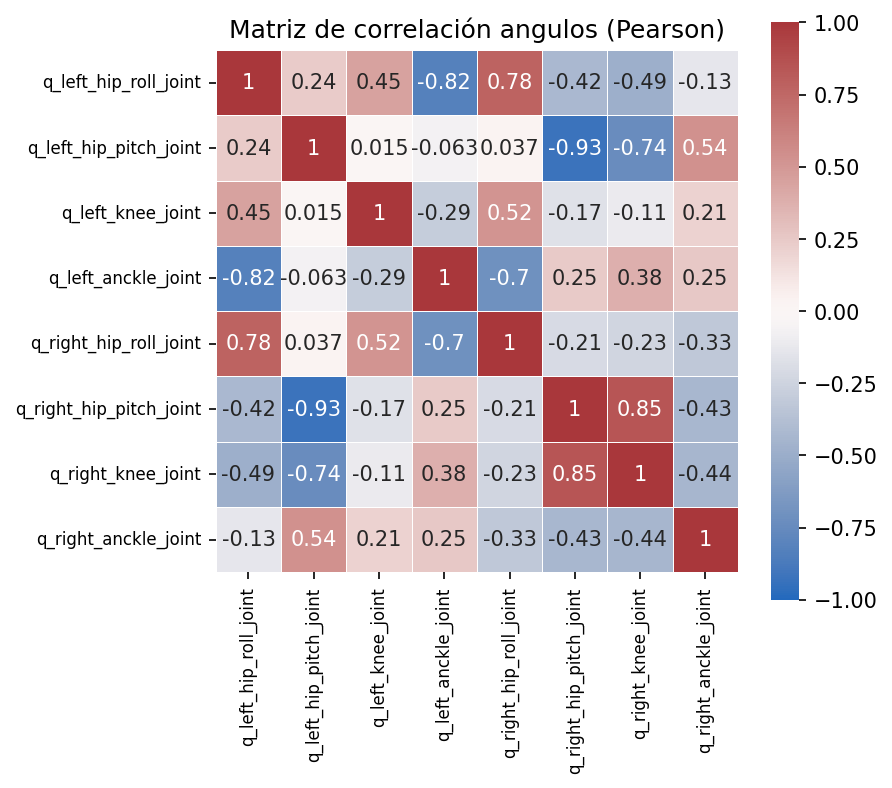

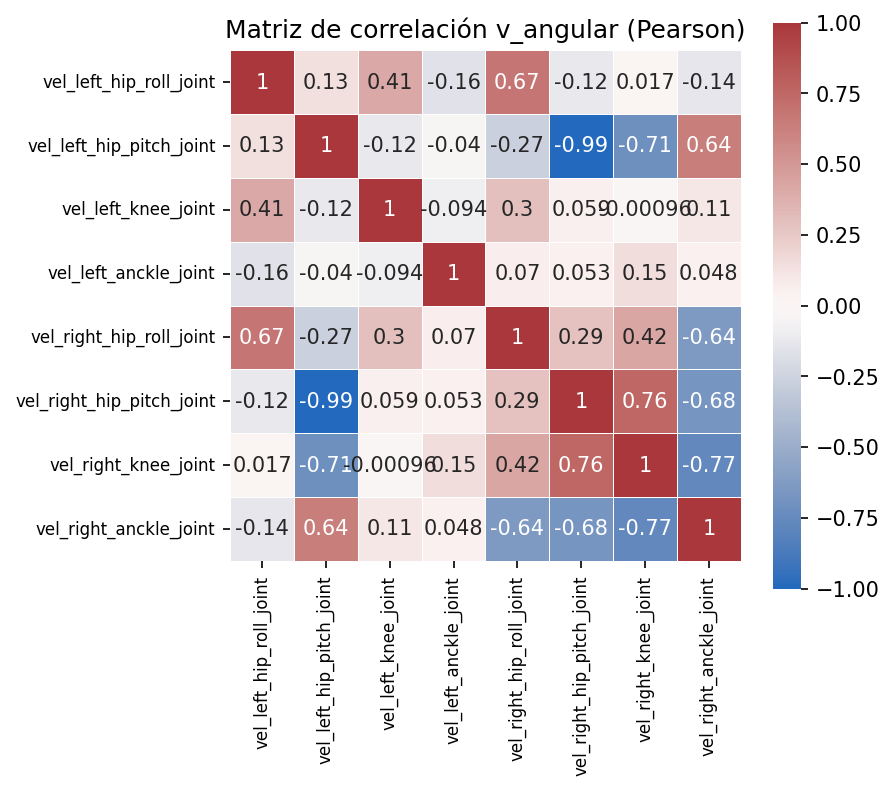

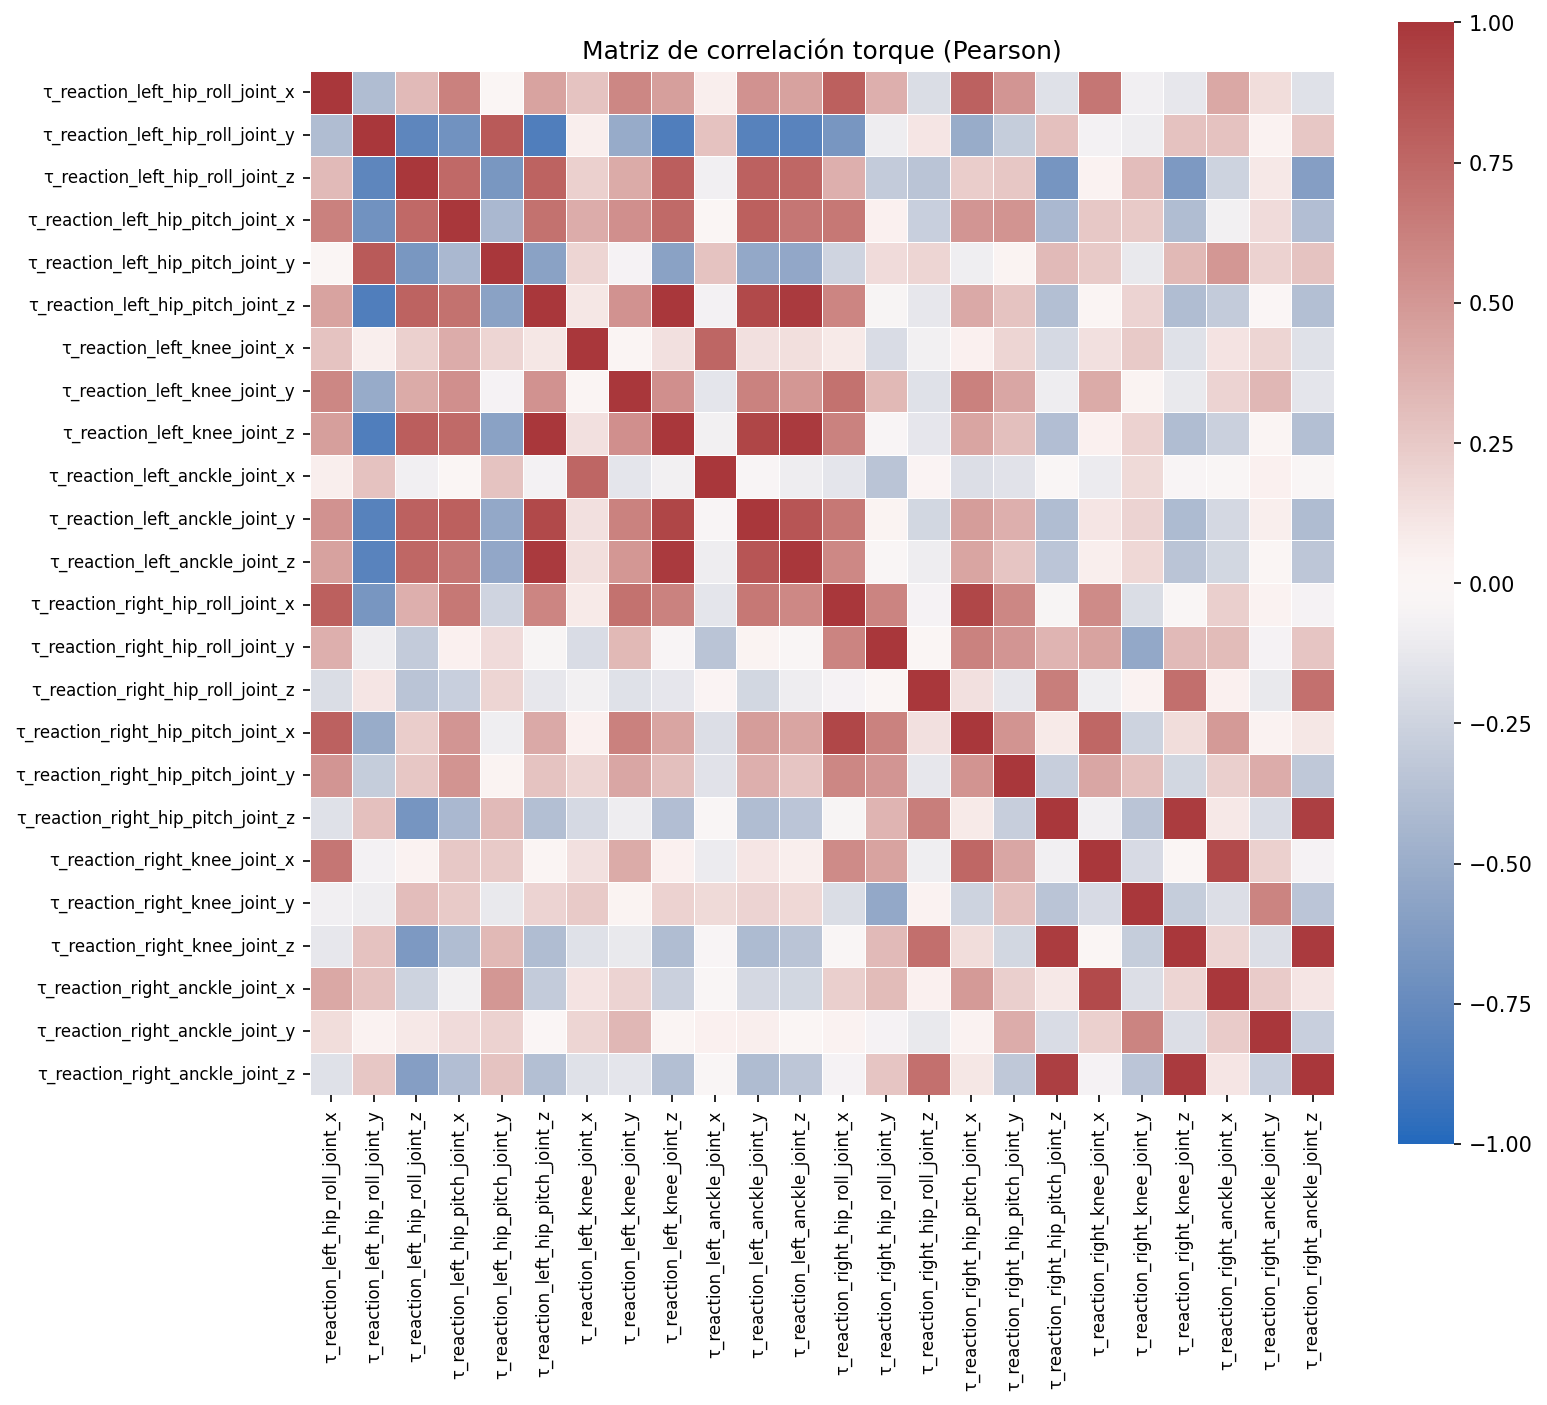

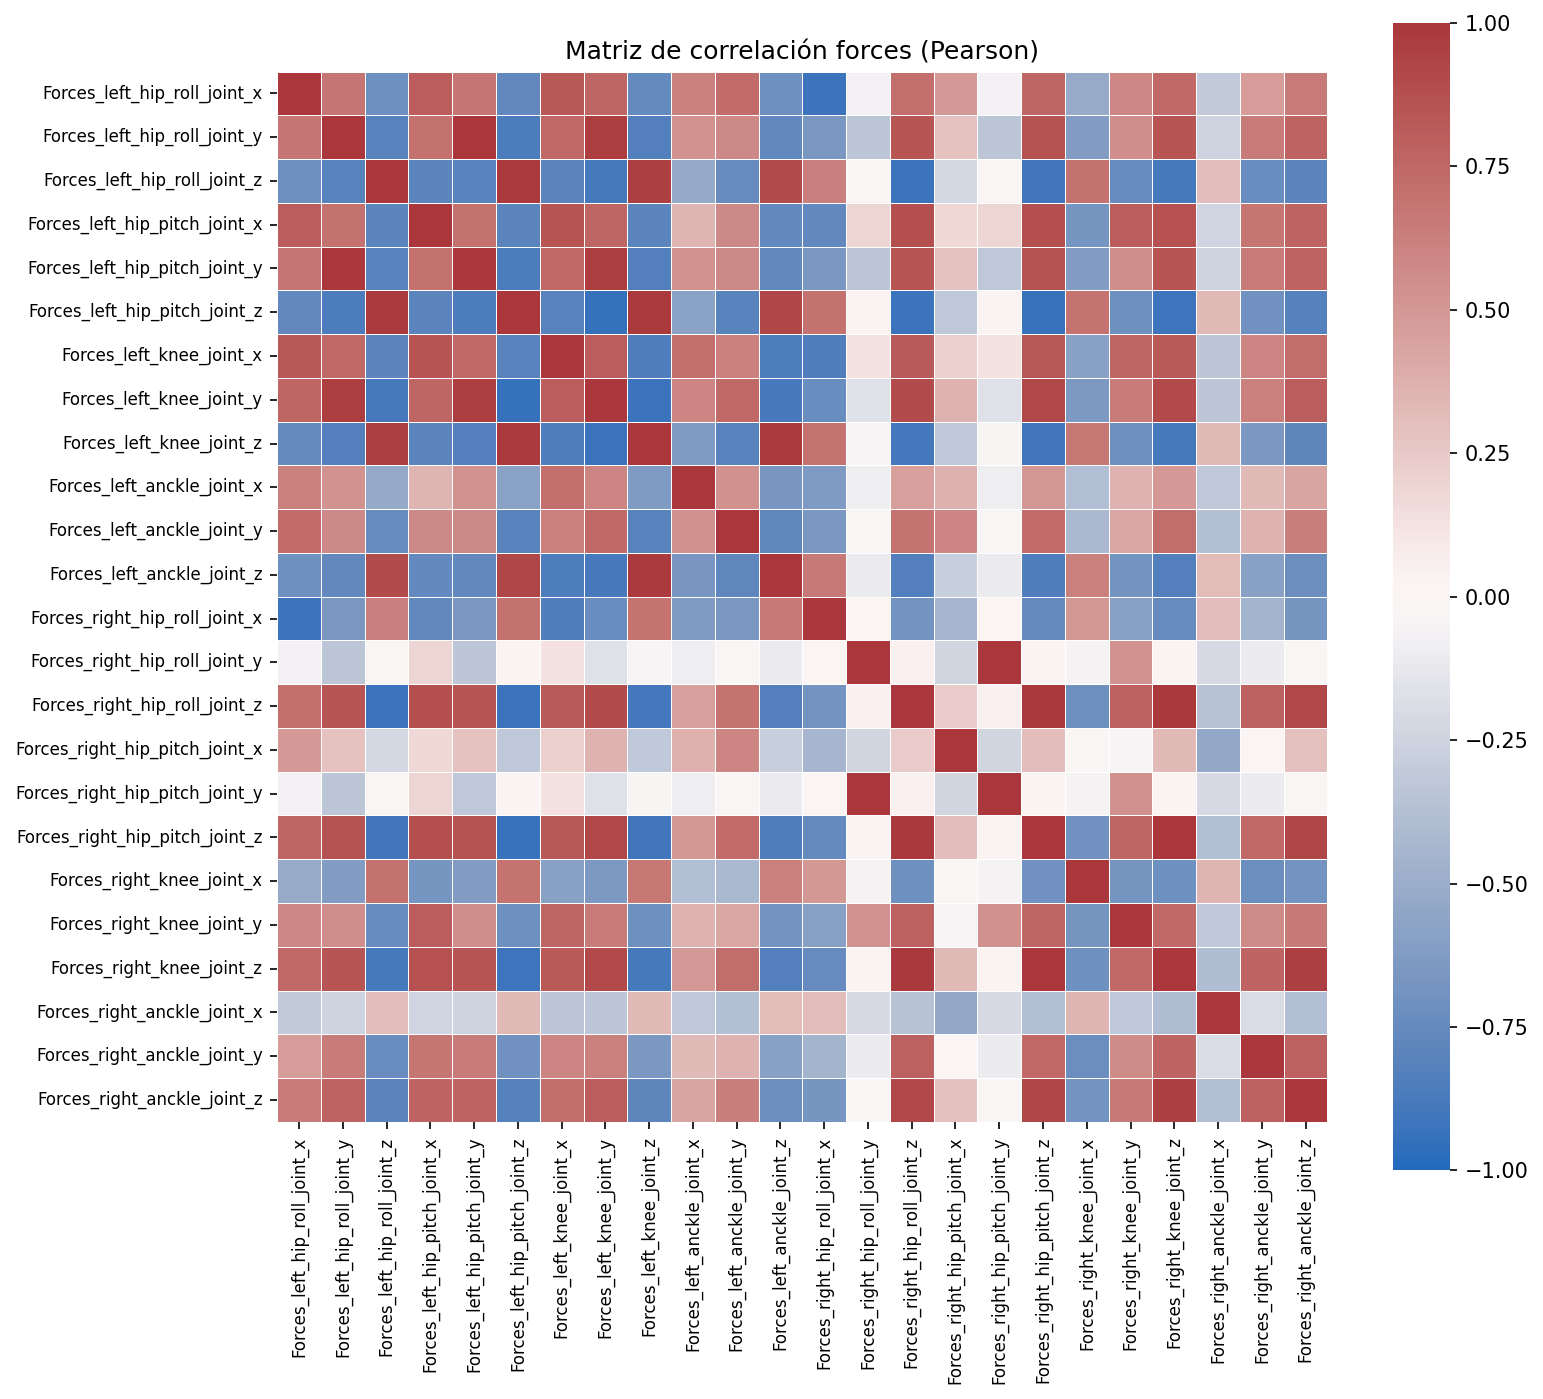

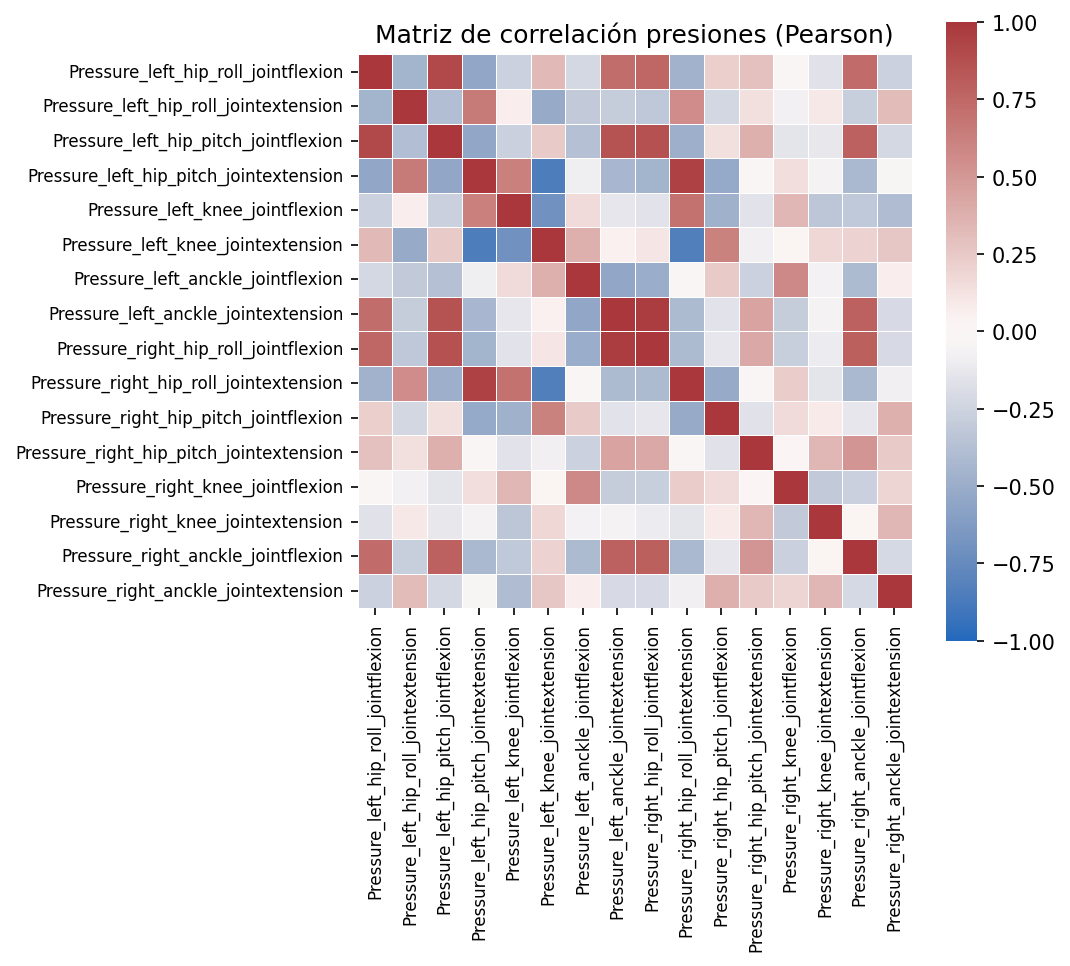

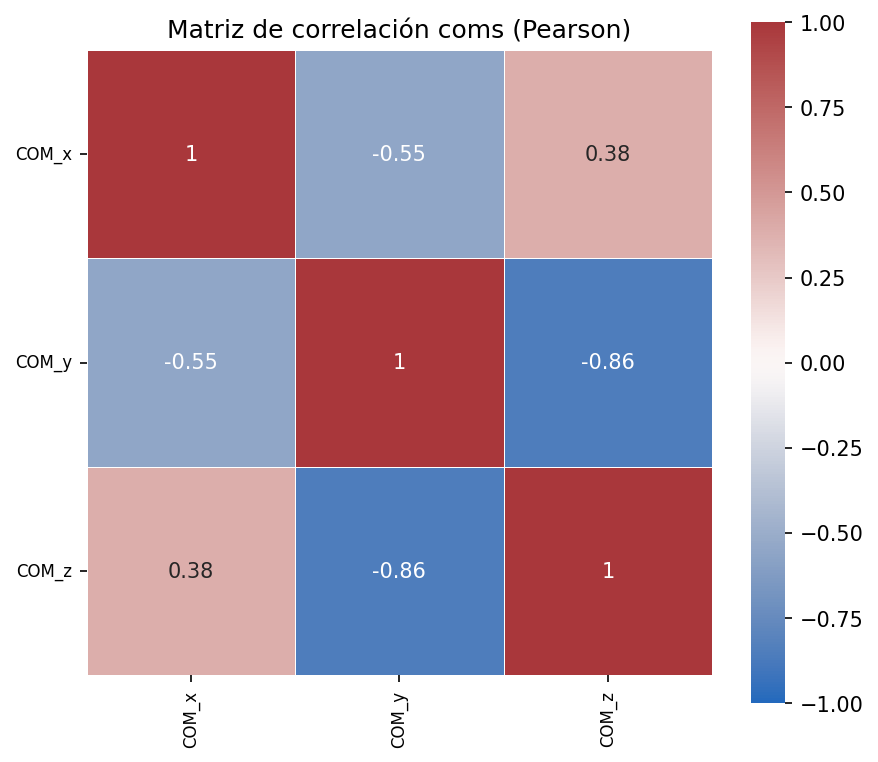

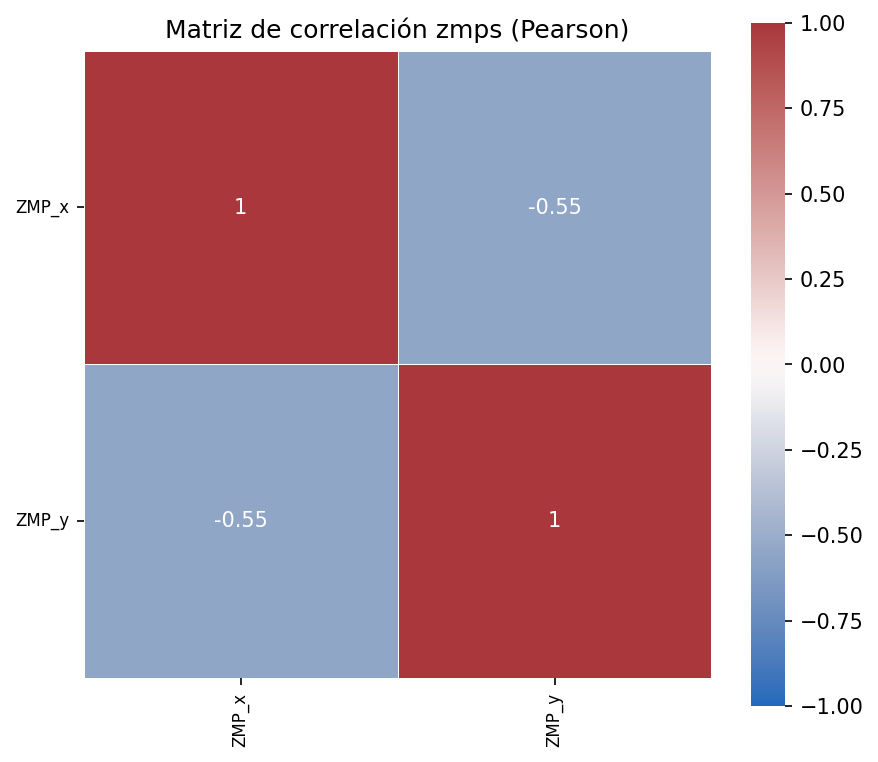

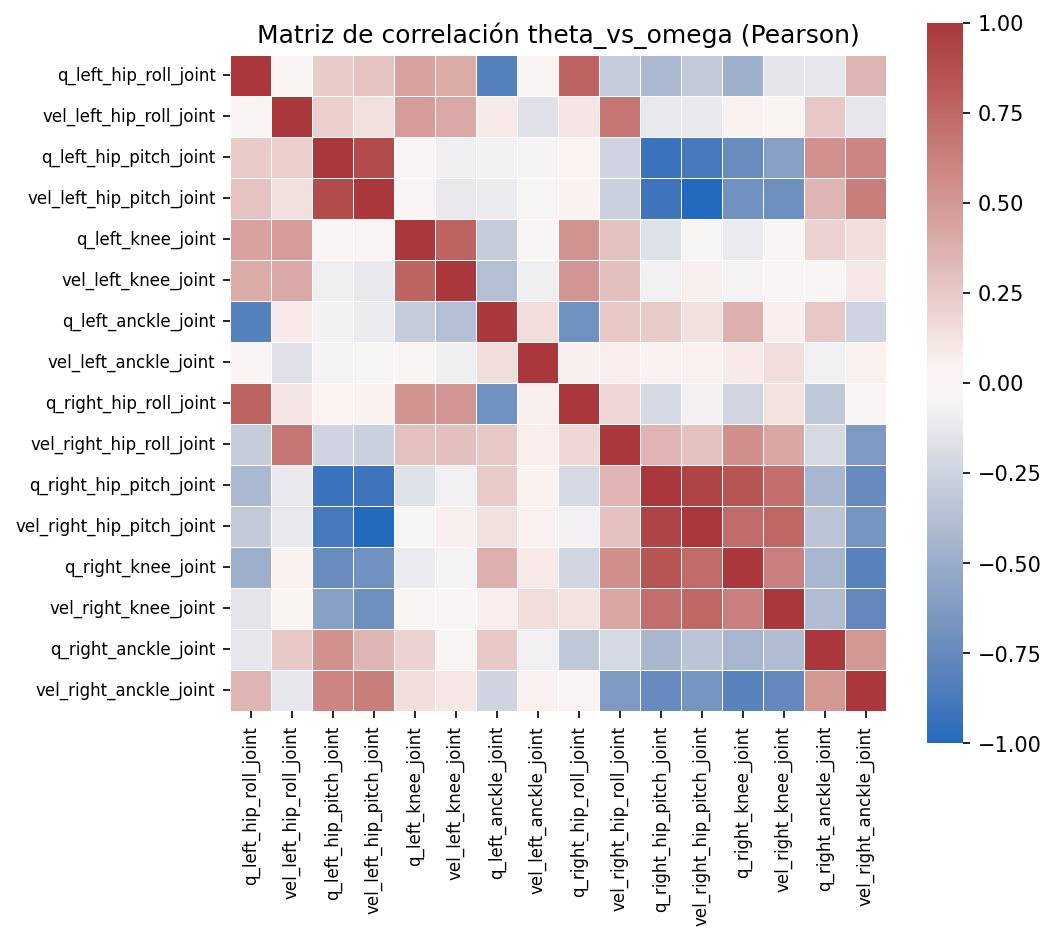

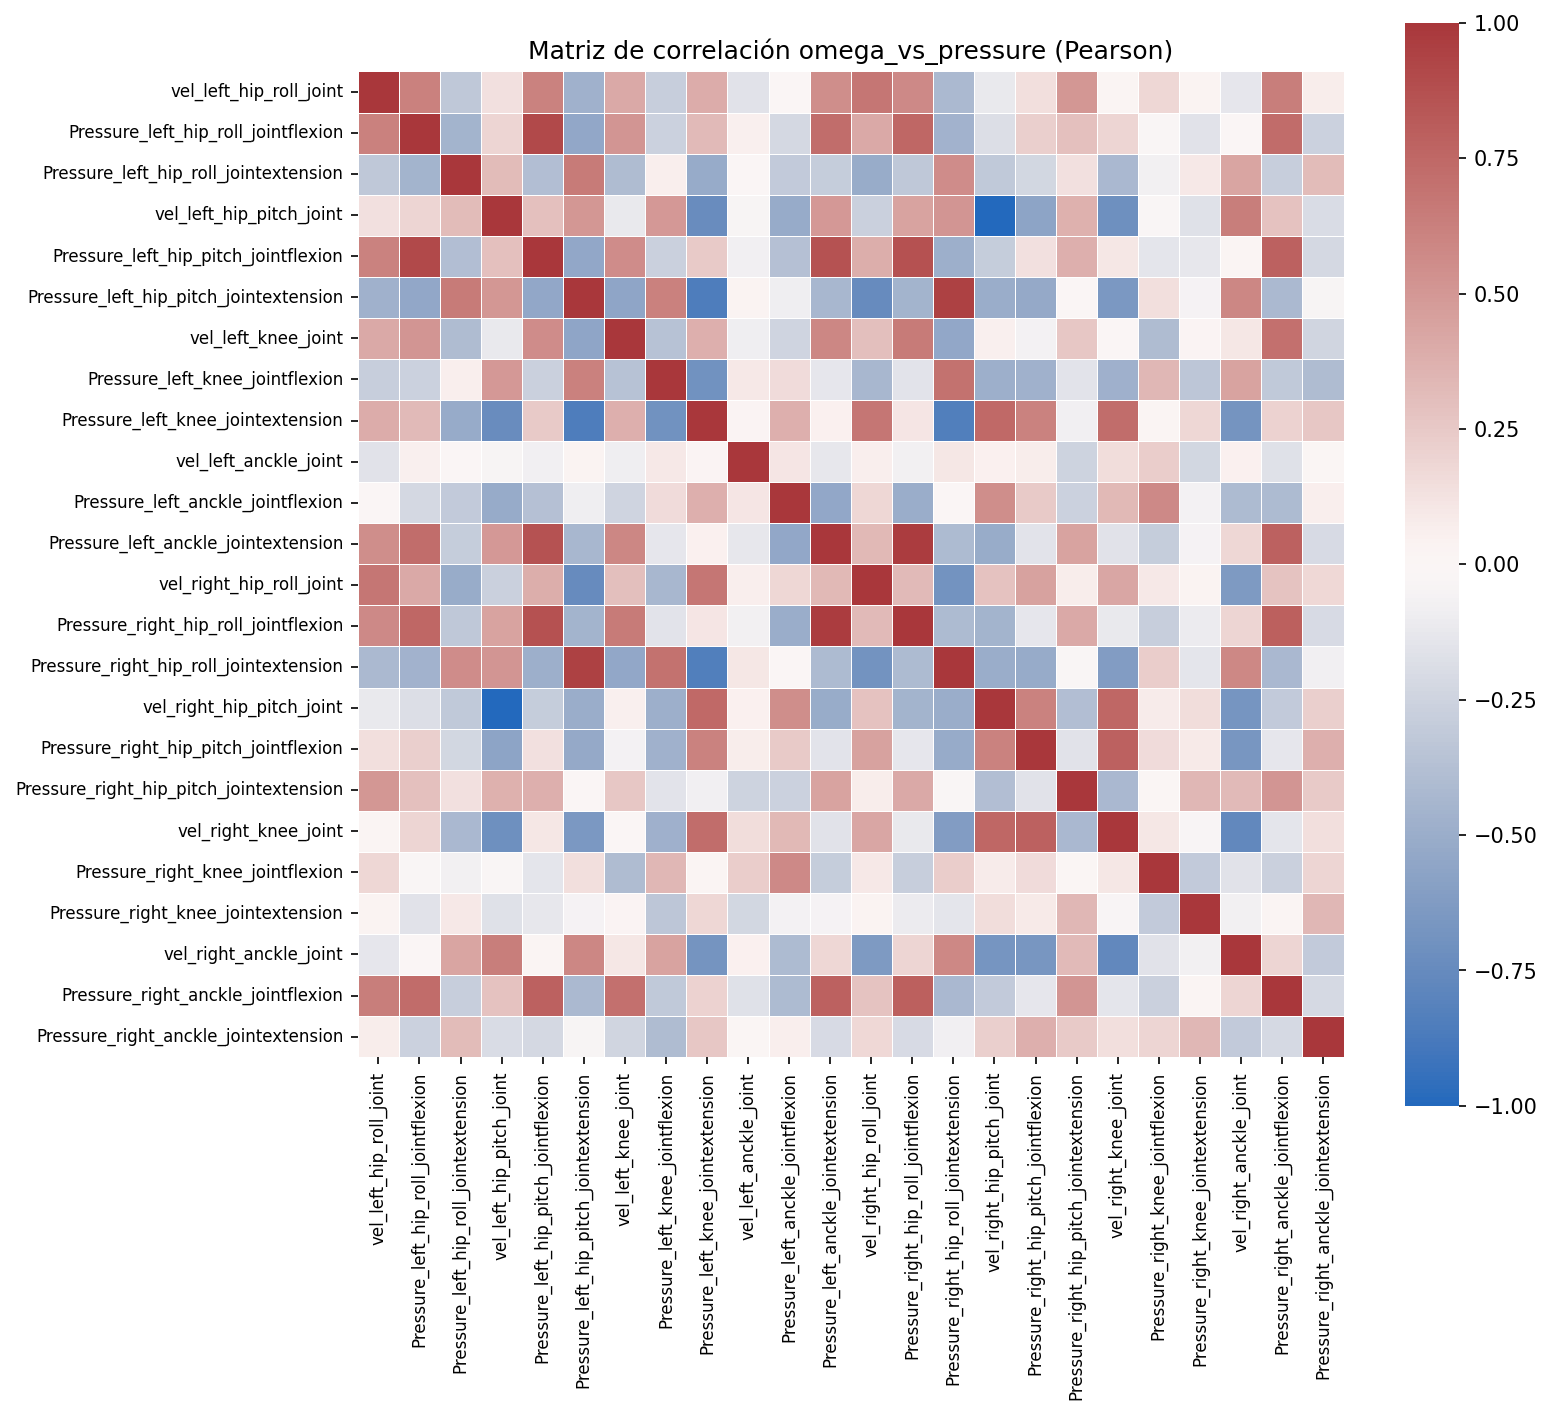

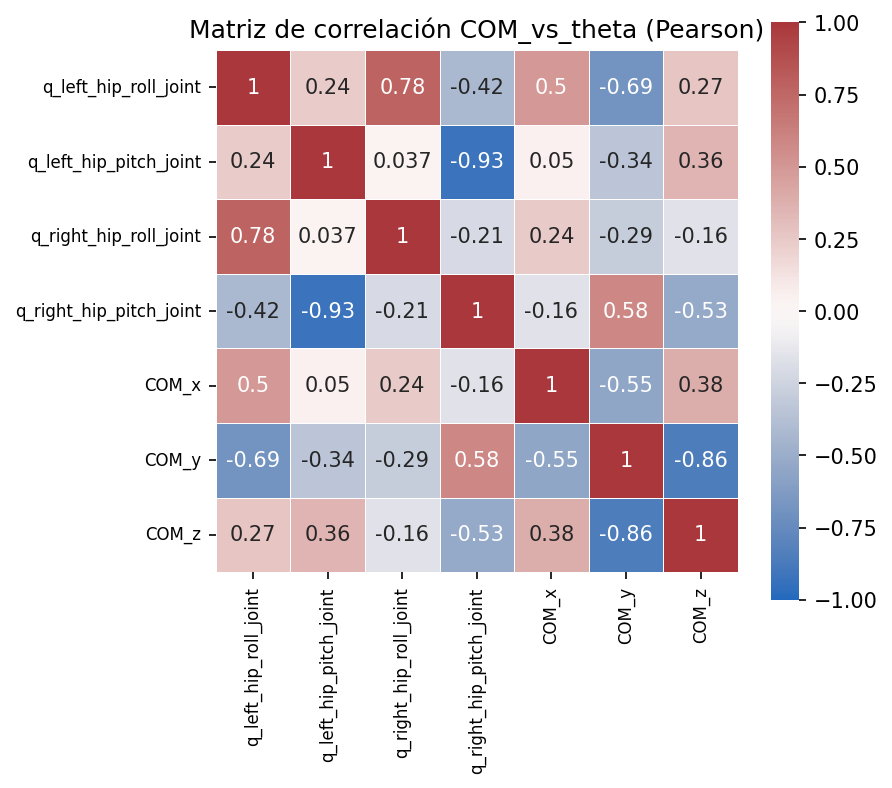

In [8]:
anglecouplinganalyzer.creacion_correlaciones(corr_angulos,"angulos")
anglecouplinganalyzer.creacion_correlaciones(corr_angular_speed, "v_angular")
anglecouplinganalyzer.creacion_correlaciones(corr_torque,"torque", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_forces, "forces", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_presiones, "presiones", annot=False)
#anglecouplinganalyzer.creacion_correlaciones(corr_recompensas, "recompensas", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_coms, "coms")
anglecouplinganalyzer.creacion_correlaciones(corr_zmp, "zmps")
anglecouplinganalyzer.creacion_correlaciones(corr_angulo_velocidad, "theta_vs_omega", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_velocidad_presiones, "omega_vs_pressure", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_com_angulo, "COM_vs_theta")